# Retail Orders Case Study

**Goal:** Demonstrate an end‑to‑end, production‑oriented data engineering pipeline.

This notebook covers:
1. **Data Extraction** 
2. **Data Profiling** 
3. **Data Cleansing / DQ** 
4. **Processing & Normalization** 
5. **Data Marts** 
6. **Visual Storytelling** 


## 1. Setup & Conventions

In [76]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
RAW_DATA_PATH = Path("../data_raw")
OUTPUTS_PATH = Path("../outputs")
STAGING_PATH = OUTPUTS_PATH / "staging"
MARTS_PATH = OUTPUTS_PATH / "marts"

OUTPUTS_PATH.mkdir(exist_ok=True)
STAGING_PATH.mkdir(exist_ok=True, parents=True)
MARTS_PATH.mkdir(exist_ok=True, parents=True)

## 2. Data Extraction

Ingest all monthly snapshots.  
Observations expected from the case:
- ANSI/latin1 encoding
- Multiple corrected versions per month, filename prefix `YYYYMM_Orders_...`


In [44]:
csv_files = sorted(RAW_DATA_PATH.glob("*.csv"))
print("# of files:", len(csv_files))
csv_files[:8]

# of files: 130


[WindowsPath('../data_raw/201901_Orders_2019_02_01_03_10_55.csv'),
 WindowsPath('../data_raw/201901_Orders_2019_02_04_15_41_32.csv'),
 WindowsPath('../data_raw/201902_Orders_2019_03_04_02_26_31.csv'),
 WindowsPath('../data_raw/201903_Orders_2019_04_01_20_39_17.csv'),
 WindowsPath('../data_raw/201903_Orders_2019_04_04_08_51_54.csv'),
 WindowsPath('../data_raw/201903_Orders_2019_04_07_08_14_44.csv'),
 WindowsPath('../data_raw/201903_Orders_2019_04_10_03_28_07.csv'),
 WindowsPath('../data_raw/201904_Orders_2019_05_02_04_10_00.csv')]

In [45]:
dfs = []
for f in csv_files:
    df = pd.read_csv(
        f,
        encoding="latin1",   
        sep="|",
        engine="python",
        quotechar='"',
        on_bad_lines="skip"
    )
    df["source_filename"] = f.name
    m = re.match(r"(\d{6})_Orders_", f.name)
    df["file_month"] = m.group(1) if m else None
    dfs.append(df)

raw_df = pd.concat(dfs, ignore_index=True)
print("Raw shape:", raw_df.shape)
raw_df.head()


Raw shape: (22157, 23)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,source_filename,file_month
0,7981,CA-2019-103800,04-01-2019,08-01-2019,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",0.0,0,0.2,5.5512,201901_Orders_2019_02_01_03_10_55.csv,201901
1,740,CA-2019-112326,05-01-2019,09-01-2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-LA-10003223,Office Supplies,Labels,Avery 508,0.0,0,0.2,4.2717,201901_Orders_2019_02_01_03_10_55.csv,201901
2,741,CA-2019-112326,05-01-2019,09-01-2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,0.0,0,0.2,-64.7748,201901_Orders_2019_02_01_03_10_55.csv,201901
3,742,CA-2019-112326,05-01-2019,09-01-2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,0.0,0,0.8,-5.4870,201901_Orders_2019_02_01_03_10_55.csv,201901
4,1760,CA-2019-141817,06-01-2019,13-01-2019,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,0.0,0,0.2,4.8840,201901_Orders_2019_02_01_03_10_55.csv,201901


In [46]:
raw_df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'source_filename', 'file_month'],
      dtype='object')

## 3. Data Profiling

Profile types, completeness, distributions, and time ranges.

### Data types

In [47]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22157 entries, 0 to 22156
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Row ID           22157 non-null  int64  
 1   Order ID         22157 non-null  object 
 2   Order Date       22157 non-null  object 
 3   Ship Date        22157 non-null  object 
 4   Ship Mode        22157 non-null  object 
 5   Customer ID      22157 non-null  object 
 6   Customer Name    22157 non-null  object 
 7   Segment          22157 non-null  object 
 8   Country          22157 non-null  object 
 9   City             22157 non-null  object 
 10  State            22157 non-null  object 
 11  Postal Code      22157 non-null  int64  
 12  Region           22157 non-null  object 
 13  Product ID       22157 non-null  object 
 14  Category         22157 non-null  object 
 15  Sub-Category     22157 non-null  object 
 16  Product Name     22157 non-null  object 
 17  Sales       

In [ ]:
raw_df.describe(include="all").T.head(25)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Row ID,22157.0,NaN,NaN,NaN,5015.414587,2874.650518,1.0,2561.0,5006.0,7524.0,9994.0
Order ID,22157,5009,CA-2020-121720,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Date,22157,1238,07-09-2019,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ship Date,22157,1334,16-12-2020,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ship Mode,22157,4,Standard Class,13138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer ID,22157,793,PP-18955,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Name,22157,793,Paul Prost,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Segment,22157,3,Consumer,11543,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,22157,1,United States,22157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,22157,531,New York City,2055,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing values

In [51]:
raw_df.isna().sum()

Row ID               0
Order ID             0
Order Date           0
Ship Date            0
Ship Mode            0
Customer ID          0
Customer Name        0
Segment              0
Country              0
City                 0
State                0
Postal Code          0
Region               0
Product ID           0
Category             0
Sub-Category         0
Product Name         0
Sales                0
Quantity             0
Discount             0
Profit             234
source_filename      0
file_month           0
dtype: int64

### Numeric profiling

In [52]:
def clean_numeric_series(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace(",", ""), errors="coerce")

In [53]:
num_df = pd.DataFrame({
    "Sales": clean_numeric_series(raw_df["Sales"]),
    "Quantity": clean_numeric_series(raw_df["Quantity"]),
    "Discount": clean_numeric_series(raw_df["Discount"]),
    "Profit": clean_numeric_series(raw_df["Profit"]),
})
num_df.describe()

,Sales,Quantity,Discount,Profit
count,22157.000000,22157.000000,22157.000000,21923.000000
mean,120.001841,1.972289,0.156228,28.108296
std,453.942364,2.481990,0.205035,237.459052
min,0.000000,-7.000000,0.000000,-6599.978000
25%,0.000000,0.000000,0.000000,1.790100
50%,4.448000,1.000000,0.200000,8.802000
75%,60.416000,3.000000,0.200000,30.204000
max,22638.480000,14.000000,0.800000,8399.976000


### Date profiling

In [54]:
order_dt = pd.to_datetime(raw_df["Order Date"], errors="coerce", dayfirst=True)
ship_dt = pd.to_datetime(raw_df["Ship Date"], errors="coerce", dayfirst=True)

order_dt.min(), order_dt.max(), ship_dt.min(), ship_dt.max()

(Timestamp('2019-01-04 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2019-01-08 00:00:00'),
 Timestamp('2023-01-06 00:00:00'))

### Categorical profiling


In [55]:
raw_df["Segment"].value_counts(dropna=False)

Segment
Consumer       11543
Corporate       6697
Home Office     3917
Name: count, dtype: int64

In [56]:
raw_df["State"].value_counts().head(10)

State
California        4371
New York          2526
Texas             2223
Pennsylvania      1325
Washington        1138
Illinois          1106
Ohio              1068
Florida            914
Michigan           550
North Carolina     549
Name: count, dtype: int64

## 4. Inconsistency detection
Implement rules for the 5 inconsistency categories described in the case.

Categories:
1. Duplicate rows across versions
2. Measure inconsistency (Sales=0 and Quantity=0 but Profit!=0)
3. Master data conflict: Product
4. Negative quantity
5. Invalid dates / missing mandatory fields

All detected rows are exported into `outputs/dq_exceptions.csv`.


In [57]:
def detect_duplicates_across_versions(df):
    mask = df.duplicated(subset=["file_month", "Row ID", "Order ID"], keep=False)
    return df.loc[mask].assign(Inconsistency="Duplicate Rows (across versions)")

def detect_measure_inconsistency(df):
    sales = clean_numeric_series(df["Sales"])
    qty = clean_numeric_series(df["Quantity"])
    profit = clean_numeric_series(df["Profit"])
    mask = (sales == 0) & (qty == 0) & (profit != 0)
    return df.loc[mask].assign(Inconsistency="Measure Inconsistency: Sales/Qty=0 but Profit≠0")

def detect_master_data_conflict_product(df):
    prod_nunique = df.groupby("Product ID")[["Category","Sub-Category","Product Name"]].nunique().max(axis=1)
    conflicted_ids = prod_nunique[prod_nunique > 1].index
    return df[df["Product ID"].isin(conflicted_ids)].assign(Inconsistency="Master Data Conflict: Product")

def detect_negative_quantity(df):
    qty = clean_numeric_series(df["Quantity"])
    mask = qty < 0
    return df.loc[mask].assign(Inconsistency="Negative Quantity")

def detect_invalid_dates_or_missing(df):
    order_parsed = pd.to_datetime(df["Order Date"], errors="coerce", dayfirst=True)
    ship_parsed  = pd.to_datetime(df["Ship Date"], errors="coerce", dayfirst=True)
    mandatory = ["Order ID","Product ID","Customer ID","Order Date","Sales"]
    missing_mask = df[mandatory].isna().any(axis=1)
    invalid_mask = order_parsed.isna() | ship_parsed.isna() | (ship_parsed < order_parsed)
    return df.loc[missing_mask | invalid_mask].assign(Inconsistency="Invalid Dates")

dq_parts = [
    detect_duplicates_across_versions(raw_df),
    detect_measure_inconsistency(raw_df),
    detect_master_data_conflict_product(raw_df),
    detect_negative_quantity(raw_df),
    detect_invalid_dates_or_missing(raw_df)
]

dq_exceptions = pd.concat([p for p in dq_parts if not p.empty], ignore_index=True)
print("Total inconsistent rows:", dq_exceptions.shape[0])
dq_exceptions["Inconsistency"].value_counts()

Total inconsistent rows: 29608


Inconsistency
Duplicate Rows (across versions)                   18862
Measure Inconsistency: Sales/Qty=0 but Profit≠0    10543
Master Data Conflict: Product                        137
Invalid Dates                                         59
Negative Quantity                                      7
Name: count, dtype: int64

### Summary counts (distinct Row ID)


In [58]:
summary_counts = (
    dq_exceptions.groupby("Inconsistency")["Row ID"]
    .nunique()
    .reset_index()
    .rename(columns={"Row ID":"Distinct Row ID Count"})
    .sort_values("Distinct Row ID Count", ascending=False)
)
summary_counts

,Inconsistency,Distinct Row ID Count
0,Duplicate Rows (across versions),6699
3,Measure Inconsistency: Sales/Qty=0 but Profit≠0,6653
2,Master Data Conflict: Product,54
1,Invalid Dates,34
4,Negative Quantity,4


In [63]:
examples = dq_exceptions.groupby("Inconsistency").head(2)
examples

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,source_filename,file_month,Inconsistency
0,7981,CA-2019-103800,04-01-2019,08-01-2019,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",0.000,0,0.2,5.5512,201901_Orders_2019_02_01_03_10_55.csv,201901,Duplicate Rows (across versions)
1,740,CA-2019-112326,05-01-2019,09-01-2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,Office Supplies,Labels,Avery 508,0.000,0,0.2,4.2717,201901_Orders_2019_02_01_03_10_55.csv,201901,Duplicate Rows (across versions)
18862,7981,CA-2019-103800,04-01-2019,08-01-2019,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",0.000,0,0.2,5.5512,201901_Orders_2019_02_01_03_10_55.csv,201901,Measure Inconsistency: Sales/Qty=0 but Profit≠0
18863,740,CA-2019-112326,05-01-2019,09-01-2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,Office Supplies,Labels,Avery 508,0.000,0,0.2,4.2717,201901_Orders_2019_02_01_03_10_55.csv,201901,Measure Inconsistency: Sales/Qty=0 but Profit≠0
29405,9255,CA-2019-168368,12-02-2019,16-02-2019,Second Class,GA-14725,Guy Armstrong,Consumer,United States,Columbia,...,Furniture,Chairs,"Global Value Mid-Back Manager's Chair, Gray",60.890,1,0.0,15.2225,201902_Orders_2019_03_04_02_26_31.csv,201902,Master Data Conflict: Product
29406,8345,US-2019-155544,21-03-2019,25-03-2019,Standard Class,GM-14440,Gary McGarr,Consumer,United States,Knoxville,...,Furniture,Furnishings,DAX Wood Document Frame,0.000,0,0.2,6.5904,201903_Orders_2019_04_01_20_39_17.csv,201903,Master Data Conflict: Product
29542,1838,CA-2019-117345,01-08-2019,05-08-2019,Standard Class,BF-10975,Barbara Fisher,Corporate,United States,Charlotte,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,17.544,-3,0.2,5.9211,201908_Orders_2019_09_01_04_02_26.csv,201908,Negative Quantity
29543,1505,CA-2020-153388,01-08-2020,07-08-2020,Standard Class,PC-19000,Pauline Chand,Home Office,United States,Los Angeles,...,Office Supplies,Art,Prang Dustless Chalk Sticks,6.720,-4,0.0,3.3600,202008_Orders_2020_09_04_19_17_33.csv,202008,Negative Quantity
29549,6475,CA-2019-149524,1/15/2019,16-01-2019,First Class,BS-11590,Brendan Sweed,Corporate,United States,Philadelphia,...,Furniture,Bookcases,Sauder Cornerstone Collection Library,0.000,0,0.5,-53.2856,201901_Orders_2019_02_01_03_10_55.csv,201901,Invalid Dates
29550,6475,CA-2019-149524,1/15/2019,16-01-2019,First Class,BS-11590,Brendan Sweed,Corporate,United States,Philadelphia,...,Furniture,Bookcases,Sauder Cornerstone Collection Library,61.960,4,0.5,-53.2856,201901_Orders_2019_02_04_15_41_32.csv,201901,Invalid Dates


In [64]:
dq_exceptions.to_csv(OUTPUTS_PATH / "dq_exceptions.csv", index=False)

## 5. Build staging tables


In [65]:
def build_orders_stg(df):
    stg = pd.DataFrame()
    stg["Row ID"] = df["Row ID"]
    stg["Order ID"] = df["Order ID"]
    stg["Customer ID"] = df["Customer ID"]
    stg["Product ID"] = df["Product ID"]

    stg["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce", dayfirst=True)
    stg["Ship Date"]  = pd.to_datetime(df["Ship Date"], errors="coerce", dayfirst=True)

    stg["Sales"]    = clean_numeric_series(df["Sales"])
    stg["Quantity"] = clean_numeric_series(df["Quantity"])
    stg["Discount"] = clean_numeric_series(df["Discount"])
    stg["Profit"]   = clean_numeric_series(df["Profit"])

    stg["Country"] = df["Country"]
    stg["City"] = df["City"]
    stg["State"] = df["State"]
    stg["Postal Code"] = df["Postal Code"]
    stg["Region"] = df["Region"]

    stg["Segment"] = df["Segment"]
    stg["Customer Name"] = df["Customer Name"]
    stg["Category"] = df["Category"]
    stg["Sub-Category"] = df["Sub-Category"]
    stg["Product Name"] = df["Product Name"]

    stg["source_filename"] = df["source_filename"]
    stg["file_month"] = df["file_month"]
    return stg

orders_stg = build_orders_stg(raw_df)
orders_stg.to_csv(STAGING_PATH / "orders_stg.csv", index=False)
orders_stg.head()

,Row ID,Order ID,Customer ID,Product ID,Order Date,Ship Date,Sales,Quantity,Discount,Profit,...,State,Postal Code,Region,Segment,Customer Name,Category,Sub-Category,Product Name,source_filename,file_month
0,7981,CA-2019-103800,DP-13000,OFF-PA-10000174,2019-01-04,2019-01-08,0.0,0,0.2,5.5512,...,Texas,77095,Central,Consumer,Darren Powers,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",201901_Orders_2019_02_01_03_10_55.csv,201901
1,740,CA-2019-112326,PO-19195,OFF-LA-10003223,2019-01-05,2019-01-09,0.0,0,0.2,4.2717,...,Illinois,60540,Central,Home Office,Phillina Ober,Office Supplies,Labels,Avery 508,201901_Orders_2019_02_01_03_10_55.csv,201901
2,741,CA-2019-112326,PO-19195,OFF-ST-10002743,2019-01-05,2019-01-09,0.0,0,0.2,-64.7748,...,Illinois,60540,Central,Home Office,Phillina Ober,Office Supplies,Storage,SAFCO Boltless Steel Shelving,201901_Orders_2019_02_01_03_10_55.csv,201901
3,742,CA-2019-112326,PO-19195,OFF-BI-10004094,2019-01-05,2019-01-09,0.0,0,0.8,-5.4870,...,Illinois,60540,Central,Home Office,Phillina Ober,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,201901_Orders_2019_02_01_03_10_55.csv,201901
4,1760,CA-2019-141817,MB-18085,OFF-AR-10003478,2019-01-06,2019-01-13,0.0,0,0.2,4.8840,...,Pennsylvania,19143,East,Consumer,Mick Brown,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,201901_Orders_2019_02_01_03_10_55.csv,201901


## 6. Master Data Qualifying


In [66]:
orders_stg["month_key"] = orders_stg["Order Date"].dt.strftime("%Y%m")

dim_product = (
    orders_stg.sort_values(["month_key","source_filename"])
    .groupby("Product ID", as_index=False)
    .agg({"Category":"last","Sub-Category":"last","Product Name":"last"})
)

dim_customer = (
    orders_stg.sort_values(["month_key","source_filename"])
    .groupby("Customer ID", as_index=False)
    .agg({"Customer Name":"last","Segment":"last"})
)

dim_product.head()


,Product ID,Category,Sub-Category,Product Name
0,FUR-BO-10000112,Furniture,Bookcases,"Bush Birmingham Collection Bookcase, Dark Cherry"
1,FUR-BO-10000330,Furniture,Bookcases,"Sauder Camden County Barrister Bookcase, Plank..."
2,FUR-BO-10000362,Furniture,Bookcases,Sauder Inglewood Library Bookcases
3,FUR-BO-10000468,Furniture,Bookcases,O'Sullivan 2-Shelf Heavy-Duty Bookcases
4,FUR-BO-10000711,Furniture,Bookcases,"Hon Metal Bookcases, Gray"


## 7. Data Marts
Exclude inconsistent rows from marts by removing Row IDs listed in `dq_exceptions`.

In [67]:
exclude_row_ids = set(dq_exceptions["Row ID"].unique())
clean_orders = orders_stg[~orders_stg["Row ID"].isin(exclude_row_ids)].copy()

clean_orders["month_key"] = clean_orders["Order Date"].dt.strftime("%Y%m")
clean_orders["delivery_days"] = (clean_orders["Ship Date"] - clean_orders["Order Date"]).dt.days

In [68]:
product_monthly_sales = (
    clean_orders.groupby(["month_key","Product ID"])
    .agg(
        total_sales=("Sales","sum"),
        total_quantity=("Quantity","sum"),
        avg_selling_price=("Sales","mean")
    )
    .reset_index()
)

state_monthly_sales = (
    clean_orders.groupby(["month_key","State"])
    .agg(
        total_sales=("Sales","sum"),
        total_orders=("Row ID","count")
    )
    .reset_index()
)

customer_segment_monthly_sales = (
    clean_orders.groupby(["month_key","Customer ID","Segment"])
    .agg(
        total_sales=("Sales","sum"),
        total_profit=("Profit","sum"),
        total_orders=("Row ID","count")
    )
    .reset_index()
)

product_state_delivery = (
    clean_orders.groupby(["month_key","State","Product ID"])
    .agg(
        avg_delivery_days=("delivery_days","mean"),
        total_orders=("Row ID","count")
    )
    .reset_index()
)

product_monthly_sales.head()


,month_key,Product ID,total_sales,total_quantity,avg_selling_price
0,201902,FUR-BO-10003966,290.666,2,290.666
1,201902,FUR-CH-10000225,129.568,2,129.568
2,201902,FUR-FU-10000221,20.320,4,20.320
3,201902,FUR-FU-10002111,14.560,2,14.560
4,201902,FUR-FU-10002298,332.940,3,332.940


### Export marts

In [70]:
product_monthly_sales.to_csv(MARTS_PATH / "product_monthly_sales.csv", index=False)
state_monthly_sales.to_csv(MARTS_PATH / "state_monthly_sales.csv", index=False)
customer_segment_monthly_sales.to_csv(MARTS_PATH / "customer_segment_monthly_sales.csv", index=False)
product_state_delivery.to_csv(MARTS_PATH / "product_state_delivery.csv", index=False)

In [71]:
marts = {
    "product_monthly_sales": MARTS_PATH / "product_monthly_sales.csv",
    "state_monthly_sales": MARTS_PATH / "state_monthly_sales.csv",
    "customer_segment_monthly_sales": MARTS_PATH / "customer_segment_monthly_sales.csv",
    "product_state_delivery": MARTS_PATH / "product_state_delivery.csv",
}

summary_rows = []

for name, file_path in marts.items():
    df = pd.read_csv(file_path)
    total_rows = len(df)

    if name == "product_monthly_sales":
        pk_count = df[["month_key", "Product ID"]].drop_duplicates().shape[0]
    elif name == "state_monthly_sales":
        pk_count = df[["month_key", "State"]].drop_duplicates().shape[0]
    elif name == "customer_segment_monthly_sales":
        pk_count = df[["month_key", "Customer ID", "Segment"]].drop_duplicates().shape[0]
    elif name == "product_state_delivery":
        pk_count = df[["month_key", "State", "Product ID"]].drop_duplicates().shape[0]
    else:
        pk_count = None

    distinct_row_id = df["Row ID"].nunique() if "Row ID" in df.columns else "N/A"

    summary_rows.append([name, total_rows, pk_count, distinct_row_id])

summary_df = pd.DataFrame(
    summary_rows,
    columns=["Table", "Total Rows", "Distinct PK Count", "Distinct Row ID"]
)

summary_df

,Table,Total Rows,Distinct PK Count,Distinct Row ID
0,product_monthly_sales,3029,3029,N/A
1,state_monthly_sales,403,403,N/A
2,customer_segment_monthly_sales,1491,1491,N/A
3,product_state_delivery,3234,3234,N/A


## 8. Visualizing KPIS

### Total sales trend over time


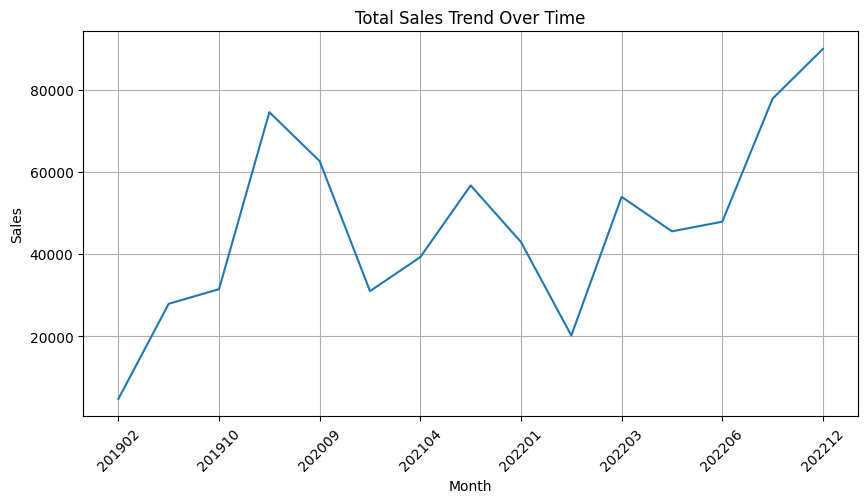

In [73]:
monthly_sales = product_monthly_sales.groupby("month_key")["total_sales"].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot(kind="line")
plt.title("Total Sales Trend Over Time")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Top 10 states by sales

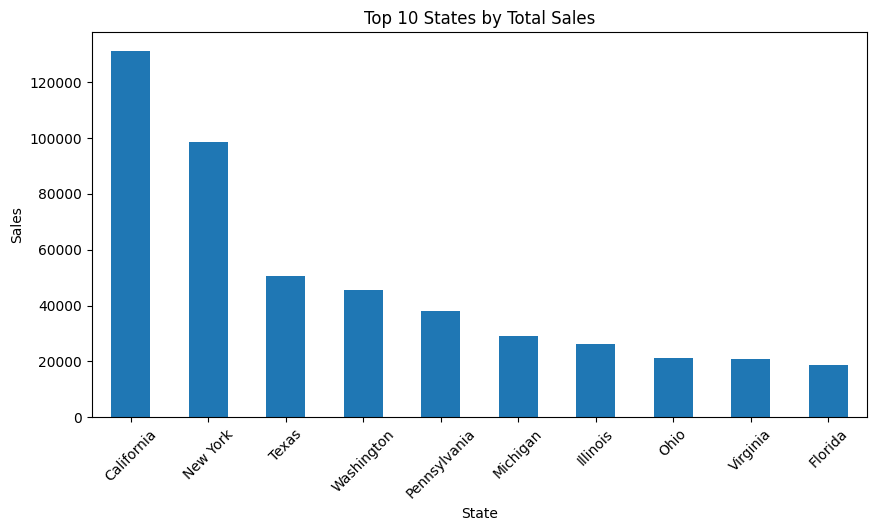

In [74]:
top_states = state_monthly_sales.groupby("State")["total_sales"].sum().nlargest(10)
plt.figure(figsize=(10,5))
top_states.plot(kind="bar")
plt.title("Top 10 States by Total Sales")
plt.ylabel("Sales")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.show()

### Distribution of Delivery Days

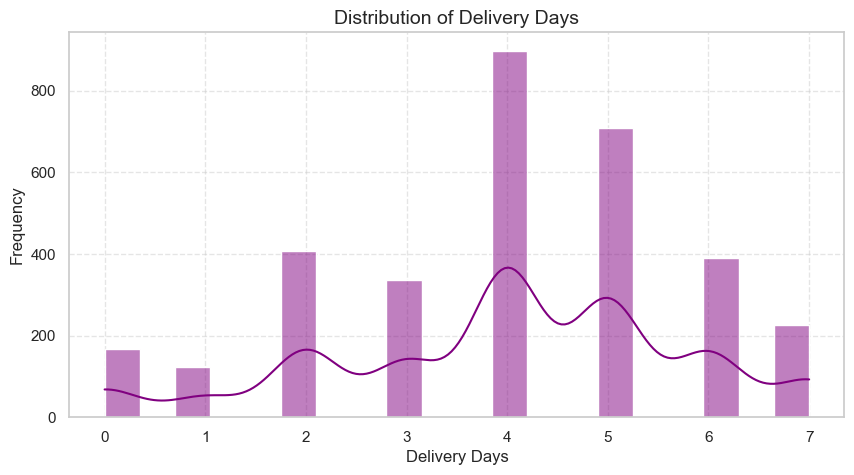

In [80]:
plt.figure(figsize=(10,5))
sns.histplot(clean_orders["delivery_days"], bins=20, kde=True, color="purple")

plt.title("Distribution of Delivery Days", fontsize=14)
plt.xlabel("Delivery Days")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## 9. Limitations & Future Enhancements

- **Orchestration:** Airflow/ADF with file‑arrival triggers for monthly loads.  
- **SCD Type 2:** Track customer/product attribute changes over time.  
- **Incremental Loads:** Process only newest month, backfill on correction.  